# Project 3 - TDCV

## Dependencies

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from Functions import *

%load_ext autoreload
%autoreload 2

## Load images

In [2]:
categ = ["ape", "benchvise", "cam", "cat", "duck"]

file = open('./dataset/real/training_split.txt', "r")
split_mask = np.int16(file.readline().split(", "))  #indices of real folder for training set

#GET IMAGES FROM FOLDERS
S_db_img, S_db_class, S_db_quat = get_images("coarse", categ, "poses.txt")
real_img, real_class, real_quat = get_images("real", categ, "poses.txt")
fine_img, fine_class, fine_quat = get_images("fine", categ, "poses.txt")

print('Real_img : ', end=''), print(real_img.shape)
print('Fine_img : ', end=''), print(fine_img.shape)

#SPLIT REAL DATA
S_train_img, S_train_class, S_train_quat, S_test_img, S_test_class, S_test_quat = split_data(
    real_img, real_class, real_quat, split_mask, 1178)

S_train_img = np.append(S_train_img, fine_img, axis = 0)
S_train_class = np.append(S_train_class, fine_class, axis = 0)
S_train_quat = np.append(S_train_quat, fine_quat, axis = 0)

print('S_db : ', end=''), print(S_db_img.shape)
print('S_train : ', end=''), print(S_train_img.shape)
print('S_test : ', end=''), print(S_test_img.shape)

assert((len(S_train_img) + len(S_test_img)) == (len(real_img) + len(fine_img)))

Real_img : (5890, 64, 64, 3)
Fine_img : (5055, 64, 64, 3)
S_db : (1335, 64, 64, 3)
S_train : (7410, 64, 64, 3)
S_test : (3535, 64, 64, 3)


## Example of Batch Generation

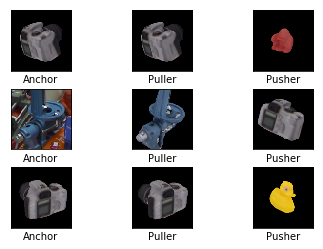

In [3]:
batch_size = 3
batch_img, batch_class, batch_quat = batch_generator(S_train_img, S_train_class, S_train_quat,
                                                     S_db_img, S_db_class, S_db_quat, batch_size)
plot_images(batch_img)

## Normalize images with values [0,1]

In [4]:
S_db_img = np.array(S_db_img, dtype="float32", copy = True)
S_train_img = np.array(S_train_img, dtype="float32", copy = True)
S_test_img = np.array(S_test_img, dtype="float32", copy = True)

for i in range(0, len(S_db_img)):
    S_db_img[i] = normalize_img(S_db_img[i])

for i in range(0, len(S_train_img)):
    S_train_img[i] = normalize_img(S_train_img[i])

for i in range(0, len(S_test_img)):
    S_test_img[i] = normalize_img(S_test_img[i])

## Network Model

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3], name='x')

#LAYERS
layer_conv1 = new_conv_layer(input=x, num_input_channels=3,
                   filter_size=8, num_filters=16, pooling=True, name="Conv1")

layer_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=16,
                   filter_size=5, num_filters=7, pooling=True, name="Conv2")

layer_flat, num_features = flatten_layer(layer_conv2, name="Flatten")
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=256, relu=True, name="FC1")
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=256, num_outputs=16, relu=False, name="FC2")

#LOSS
loss = total_loss(layer_fc2)

#TYPE OF OPTIMIZER
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(loss)

#SIZES
print(x)
print(layer_conv1)
print(layer_conv2)
print(layer_fc1)
print(layer_fc2)

Tensor("x:0", shape=(?, 64, 64, 3), dtype=float32)
Tensor("MaxPool:0", shape=(?, 28, 28, 16), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 12, 12, 7), dtype=float32)
Tensor("Relu_2:0", shape=(?, 256), dtype=float32)
Tensor("add_3:0", shape=(?, 16), dtype=float32)


## Training the model

In [10]:
batch_size = 32
epochs = 250
iterations_per_epoch = max(len(S_train_img) // batch_size, 1)
num_iterations = epochs * iterations_per_epoch

init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=None)

logs_path = './logs'
tf.summary.scalar("loss", loss)
merged_summary = tf.summary.merge_all()

with tf.Session() as sess:

    sess.run(init)
    summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
    hist_angles = []
    
    for i in range(0, num_iterations):
        batch_img, batch_class, batch_quat = batch_generator(S_train_img, S_train_class, S_train_quat,
                                                     S_test_img, S_test_class, S_test_quat, batch_size)

        _, loss_val, summary = sess.run([optimizer, loss, merged_summary], feed_dict={x: batch_img})

        if i % 10 == 0:
            summary_writer.add_summary(summary, i)
            
        if i % 1000 == 0:
            print("Loss value at iteration " + str(i) + "/" + str(num_iterations-1) + " : " + str(loss_val))
            save_path = saver.save(sess, "./checkpoint/model" + str(i) + ".ckpt")

            db_features, test_features = output_features(S_db_img, S_test_img, layer_fc2, loss, x, i)
            hist, indeces, _ = matching_feature_map(db_features, test_features, S_db_class, S_test_class, S_db_quat, S_test_quat)
            hist_angles.append(hist)
            save_histogram(hist, i)
            print(hist), print()
            
    save_path = saver.save(sess, "./checkpoint/model.ckpt")
    
save_plot_angles(hist_angles)
summary_writer.close()

Loss value at iteration 0/57749 : 7.49078
INFO:tensorflow:./checkpoint/model0.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model0.ckpt
[  0.28288543   1.35785007   6.22347949  31.25884017]

Loss value at iteration 1000/57749 : 0.660583
INFO:tensorflow:./checkpoint/model1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model1000.ckpt
[  4.83734088  23.79066478  55.10608204  97.79349364]

Loss value at iteration 2000/57749 : 0.236703
INFO:tensorflow:./checkpoint/model2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model2000.ckpt
[  7.80763791  35.36067893  71.17397454  99.46251768]

Loss value at iteration 3000/57749 : 0.214736
INFO:tensorflow:./checkpoint/model3000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from .

[  18.98161245   61.4427157    94.51202263  100.        ]

Loss value at iteration 30000/57749 : 0.052001
INFO:tensorflow:./checkpoint/model30000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model30000.ckpt
[  17.93493635   61.4427157    94.08769448  100.        ]

Loss value at iteration 31000/57749 : 0.0402584
INFO:tensorflow:./checkpoint/model31000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model31000.ckpt
[  22.00848656   65.54455446   94.79490806  100.        ]

Loss value at iteration 32000/57749 : 0.051529
INFO:tensorflow:./checkpoint/model32000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Restoring parameters from ./checkpoint/model32000.ckpt
[  17.73691655   58.41584158   93.04101839  100.        ]

Loss value at iteration 33000/57749 : 0.0388913
INFO:tensorflow:./checkpoint/model33000.ckpt is not 

## Choose saved model

In [ ]:
index_saved_model = 55000
db_features, test_features = output_features(S_db_img, S_test_img, layer_fc2, loss, x, index_saved_model)
hist, indeces, conf_matrix = matching_feature_map(db_features, test_features, S_db_class, S_test_class, S_db_quat, S_test_quat)
print(hist)

INFO:tensorflow:Restoring parameters from ./checkpoint/model55000.ckpt


## PCA for feature map (16D → 3D)

In [8]:
LOG_DIR = './logs'
names = ["ape", "benchvise", "cam", "cat", "duck"]

#CLASSIFY TEST DATA FOR LABEL IN PCA 3D
metadata_file = open(os.path.join(LOG_DIR, 'metadata.tsv'), 'w')
metadata_file.write('Name\tClass\n')
for i in range(len(S_test_class)):
    metadata_file.write('%06d\t%s\n' % (i, names[S_test_class[i]]))
metadata_file.close() 


with tf.Session() as sess:
    
    embedding_var = tf.Variable(test_features,  name='feature_map')
    sess.run(embedding_var.initializer)
    
    summary_writer = tf.summary.FileWriter(LOG_DIR)
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_var.name

    #metadata
    embedding.metadata_path = os.path.join('metadata.tsv')

    projector.visualize_embeddings(summary_writer, config)
    saver = tf.train.Saver([embedding_var])
    saver.save(sess, os.path.join(LOG_DIR, 'model2.ckpt'), 1)

## Confusion matrix

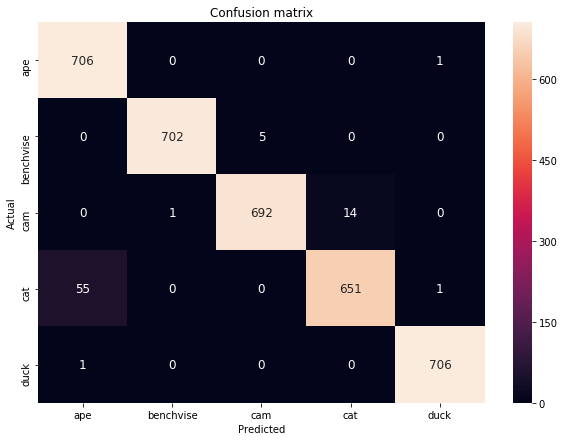

In [7]:
names = ['ape', 'benchvise', 'cam', 'cat', 'duck']
conf_matrix = np.array(conf_matrix, copy = True, dtype = "int16")

df = pd.DataFrame(conf_matrix, index = names, columns = names)

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df, annot=True, annot_kws={"size": 12}, fmt="d")
ax.set_title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.clf()
plt.cla()
plt.close()